# Projet 8 : Déployez un modèle dans le cloud

Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.


Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.



Votre mission :

- Vous êtes donc chargé de vous approprier les travaux réalisés par l’alternant et de compléter la chaîne de traitement.

- Il n’est pas nécessaire d’entraîner un modèle pour le moment.

- L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

# Sommaire

## I. Importation
### 1. Importation des bibliothèques
### 2. Importation des données

## II. Preprocessing et extraction des features
### 1. Préparation des fonctions d'extraction et de redimensionnements
### 2. Extraction des features

## III. ACP
### 1. Standardisation
### 2. ACP
### 3. Sauvegarde des données

## IV. Conclusion

## I. Importation

### 1. Importation des bibliothèques

In [1]:

import time
import os
import io
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pyarrow
import pandas as pd
import subprocess



# Oyspark
import pyspark 
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

# Tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Divers
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import warnings
import logging
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')


Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
10,application_1689700020656_0011,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Importation des données

In [2]:
# Importation avec le Path

PATH = 's3://projet8buriez'
PATH_Data = PATH+'/Donnees/'
PATH_Result = PATH_Data+'/Results/'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://projet8buriez
PATH_Data:   s3://projet8buriez/Donnees/
PATH_Result: s3://projet8buriez/Donnees//Results/

In [3]:
# Importation des images avec le format .jpg

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Vérification du jeu de données et ajout du label

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))
print('Nous avons', images.count(), 'dans notre dataframe')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------+--------------+
|path                                                           |label         |
+---------------------------------------------------------------+--------------+
|s3://projet8buriez/Donnees/Results/Apple Braeburn/r_146_100.jpg|Apple Braeburn|
|s3://projet8buriez/Donnees/Results/Apple Braeburn/r_12_100.jpg |Apple Braeburn|
|s3://projet8buriez/Donnees/Results/Cocos/r_56_100.jpg          |Cocos         |
|s3://projet8buriez/Donnees/Results/Cocos/r_153_100.jpg         |Cocos         |
|s3://projet8buriez/Donnees/Results/Cocos/r_127_100.jpg         |Cocos         |
+---------------------------------------------------------------+--------------+
only showing top 5 rows

None
Nous avons 80 dans notre datafr

Comme nous pouvons le constater, notre première étape, à savoir l'importation des bibliothèques et l'importation de notre jeu de données avec le label ont parfaitement fonctionné.
Nous remarquons également que nos données bénéficient d'un label et que l'ensemble du panel que nous avons créé est chargé.

A présent, nous allons procéder à l'étape de préparation de notre modèle

## II. Preprocessing et extraction des features
### 1. Préparation des fonctions d'extraction et de redimensionnements

Dans cette seconde étape, l'objectif sera tout simplement de procéder à la création de notre modèle. Le but de ce dernier étant de permettre une extraction des features.

Afin de réaliser cette étape, nous allons prendre la décision d'utiliser un modèle de RESNET50 dans le cadre d'un modèle de Transfer Learning.

Dans le cadre du projet initial, le modèle utilisé est un MobileNetV2, nous avons pris l'optique d'entraîner un modèle avec un nombre de paramètres plus important.

In [5]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

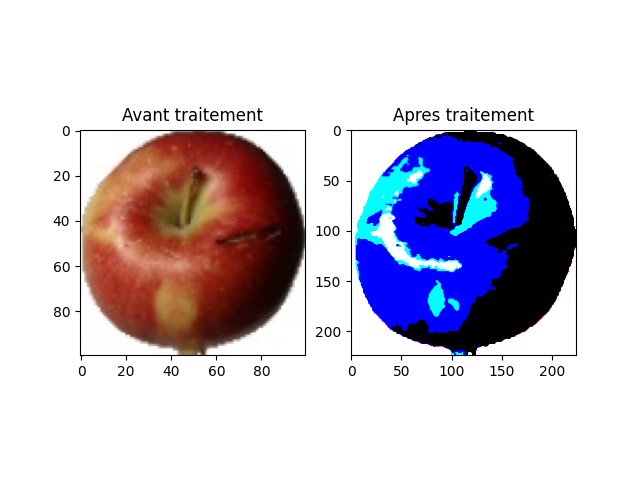

In [8]:
# Graphique pour représenter avant et après redimensionnement.

img = images.first()["content"]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Image.open(io.BytesIO(img)))
axs[0].set_title('Avant traitement')
axs[1].imshow(preprocess(img))
axs[1].set_title('Apres traitement')
plt.show()

# pour afficher plot sur notebook EMR
%matplot plt

In [9]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Extraction des features

In [10]:
# Chargement du modèle
model = ResNet50(include_top=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#variable de diffusion. Les variables de diffusion permettent au programmeur de conserver une variable en lecture seule en cache sur chaque machine plutôt que d'en expédier une copie avec les tâches. Ils peuvent être utilisés, par exemple, pour donner à chaque nœud une copie d'un grand ensemble de données d'entrée de manière efficace. Spark tente également de distribuer des variables de diffusion à l'aide d'algorithmes de diffusion efficaces pour réduire les coûts de communication.

bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Appliquer la feature_udf sur content

df_features_extraction = images.select(col("path"), col("label"), featurize_udf("content").alias("features"))
df_features_extraction.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [13]:
# afficher la features extractions Resnet50
df_features_extraction.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3://projet8burie...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|s3://projet8burie...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|s3://projet8burie...|         Cocos|[0.0, 0.0, 0.0, 0...|
|s3://projet8burie...|         Cocos|[0.0, 0.0, 0.0, 0...|
|s3://projet8burie...|         Cocos|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------+--------------------+
only showing top 5 rows

Notre jeu de données présentent bien notre path, le label et notre extraction des features.

A présent, nous allons juste transformer notre variable features en format 'vecteur'.
Ce format sera essentiel lors de notre ACP.

In [14]:
# transform to vector 
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_features_extraction_1 = df_features_extraction.select(col("path"),  col("label"), to_vector(df_features_extraction["features"]).alias("features")) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## III. ACP

### 1. Standardisation

Dans le cadre de notre ACP, nous souhaitons procéder à une standardisation des données, voici notamment les différentes raisons de notre choi

- Égaliser les échelles des features : Lorsque vous utilisez un modèle de Transfer Learning pré-entraîné, les features extraites peuvent avoir des échelles différentes. La standardisation permet de mettre toutes les features à la même échelle, en éliminant les différences de magnitude entre les valeurs. Cela est important pour l'ACP, car cette méthode repose sur les variances des features pour déterminer leur importance relative.

- Éviter une dominance des features : Si certaines features ont des échelles beaucoup plus grandes que d'autres, elles peuvent dominer l'analyse en contribuant de manière disproportionnée à la variance totale des données. Cela peut entraîner une distorsion des résultats de l'ACP, en mettant l'accent sur les features à grande échelle plutôt que sur leur structure sous-jacente. En standardisant les données, vous éliminez cette dominance potentielle et permettez à toutes les features de contribuer de manière équilibrée à l'analyse.

- Faciliter l'interprétation des résultats : La standardisation des données dans le cadre de l'ACP facilite l'interprétation des résultats, car les charges des composantes principales (CP) deviennent directement interprétables. Les charges représentent les corrélations entre les features et les CP, et en standardisant les données, les charges peuvent être interprétées comme des corrélations partielles. Cela permet de mieux comprendre quelles features contribuent le plus à chaque CP et d'identifier les relations significatives entre les features et les composantes.





In [15]:
# standardiser les features extractions Resnet50
scaler = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='features_StandardScaler')
scaler_fit = scaler.fit(df_features_extraction_1)
df_features_scaled = scaler_fit.transform(df_features_extraction_1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Afficher features extractions scaled avec standarscaler
df_features_scaled.printSchema()
df_features_scaled.show(5) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_StandardScaler: vector (nullable = true)

+--------------------+--------------+--------------------+-----------------------+
|                path|         label|            features|features_StandardScaler|
+--------------------+--------------+--------------------+-----------------------+
|s3://projet8burie...|Apple Braeburn|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|
|s3://projet8burie...|Apple Braeburn|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|
+--------------------+--------------+--------------------+-----------------------+
only showing top 5 rows

### 2. ACP

In [17]:
# Préparation ACP
PCA = PCA(k=10, inputCol="features_StandardScaler", outputCol="features_pca")

# Entrainement de notre ACP
model_PCA_fit = PCA.fit(df_features_scaled)
PCA_transformed = model_PCA_fit.transform(df_features_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# afficher dataframe avec features PCA
PCA_transformed.printSchema()
PCA_transformed.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_StandardScaler: vector (nullable = true)
 |-- features_pca: vector (nullable = true)

+--------------------+--------------+--------------------+-----------------------+--------------------+
|                path|         label|            features|features_StandardScaler|        features_pca|
+--------------------+--------------+--------------------+-----------------------+--------------------+
|s3://projet8burie...|Apple Braeburn|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|[21.4537935038378...|
|s3://projet8burie...|Apple Braeburn|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|[22.5288592661019...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|[9.04341621303802...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,...|   [0.0,0.0,0.0,0.0,...|[7.64634716531026...|
|s3://projet8burie...|         Cocos|[0.0,0.0,0.0,0.0,

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

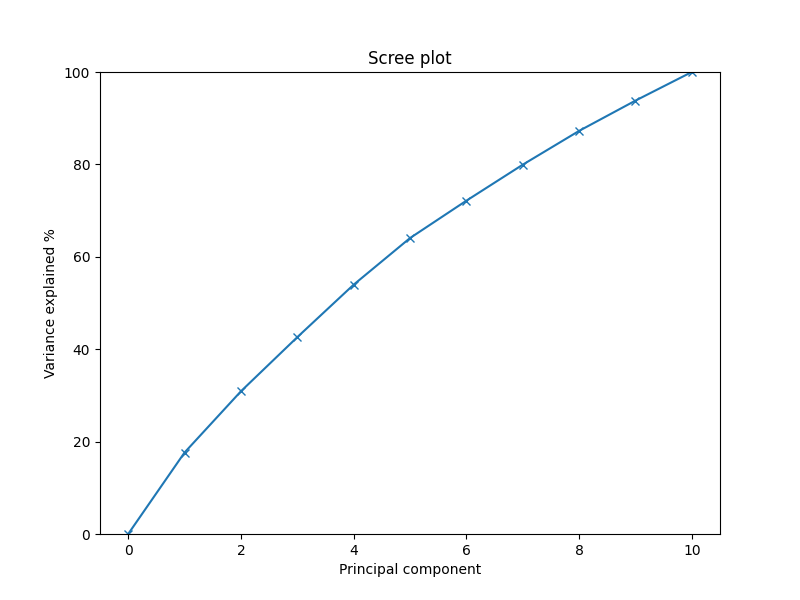

In [19]:
var = model_PCA_fit.explainedVariance.cumsum()

# Graphique
plt.figure(figsize=(8, 6))
plt.plot(range(11), np.insert(var, 0, 0) * 100, marker="x")
plt.title("Graphique de variation cumulée")
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée en %')
plt.ylim(0, 100)
plt.show()


# pour afficher plot sur notebook EMR
%matplot plt

In [20]:
# Select colonnes et transform pandas
transformed_final = PCA_transformed.select('path', 'label', 'features_pca')
df_pandas = transformed_final.toPandas()
df_pandas

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                 path  ...                                       features_pca
0   s3://projet8buriez/Donnees/Results/Apple Braeb...  ...  [21.45379350383786, -7.836557319278415, 10.832...
1   s3://projet8buriez/Donnees/Results/Apple Braeb...  ...  [22.528859266101982, -10.279701198386528, 6.42...
2   s3://projet8buriez/Donnees/Results/Cocos/r_56_...  ...  [9.043416213038029, 7.28147378879395, -58.5060...
3   s3://projet8buriez/Donnees/Results/Cocos/r_153...  ...  [7.646347165310267, 5.547783711816382, -60.871...
4   s3://projet8buriez/Donnees/Results/Cocos/r_127...  ...  [7.741595631130213, 4.169217728468483, -64.412...
..                                                ...  ...                                                ...
75  s3://projet8buriez/Donnees/Results/Banana/325_...  ...  [-86.47663292065997, 146.47120687378904, 55.25...
76  s3://projet8buriez/Donnees/Results/Banana/175_...  ...  [-138.42637661292312, 226.12991268086344, 214....
77  s3://p

### 3. Sauvegarde des données

In [21]:
df_pandas[['label', 'features_pca']]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             label                                       features_pca
0   Apple Braeburn  [21.45379350383786, -7.836557319278415, 10.832...
1   Apple Braeburn  [22.528859266101982, -10.279701198386528, 6.42...
2            Cocos  [9.043416213038029, 7.28147378879395, -58.5060...
3            Cocos  [7.646347165310267, 5.547783711816382, -60.871...
4            Cocos  [7.741595631130213, 4.169217728468483, -64.412...
..             ...                                                ...
75          Banana  [-86.47663292065997, 146.47120687378904, 55.25...
76          Banana  [-138.42637661292312, 226.12991268086344, 214....
77          Banana  [-183.15662658334008, 40.02523260961514, -217....
78          Banana  [-106.46117629643481, 163.95049148870194, -157...
79          Banana  [-144.27131037515633, 186.20591174284016, -113...

[80 rows x 2 columns]

In [22]:
# Sauvegarder le DataFrame Pandas au format CSV localement
file_name = 'Results.csv'
df_pandas.to_csv(file_name, index=False)

# Chemin de destination sur Amazon S3
bucket_name = 'projet8buriez'
folder_path = 'jupyter/jovyan/'
s3_destination_path = f's3://{bucket_name}/{folder_path}'

# Envoyer le fichier CSV vers Amazon S3 en utilisant AWS CLI
result = subprocess.run(['aws', 's3', 'cp', file_name, s3_destination_path], capture_output=True, text=True)

if result.returncode == 0:
    print("Le fichier a ete sauvegarde avec succes dans Amazon S3.")
else:
    print("Une erreur s'est produite lors de la sauvegarde du fichier dans Amazon S3.")
    print("Message d'erreur :", result.stderr)

# Supprimer le fichier CSV local après l'envoi vers Amazon S3
os.remove(file_name)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Le fichier a ete sauvegarde avec succes dans Amazon S3.

Nous avons finalisé la sauvegarde de notre fichier sur un format csv. Ce dernier est présent dans notre répertoire contenant l'ensemble de nos fichiers.

Nous avons maintenu une décision de travailler avec un fichier sauvegardé en format csv pour tout projet futur en local.

## IV. Conclusion

En conclusion, nous pouvons affirmer avoir réussi le déploiement d'un modèle sur le cloud, une étape fondamentale de notre projet. Grâce à l'utilisation d'AWS, nous avons pu tirer parti de ses fonctionnalités puissantes, telles que le stockage des données, la création d'un cluster et le tunneling, ainsi que l'utilisation de JupyterHub pour faciliter le développement.

Nous avons réalisé avec succès les différentes étapes nécessaires à notre déploiement, notamment le chargement des PATH, le redimensionnement des images, la labelisation, l'analyse en composantes principales (ACP) et la sauvegarde des caractéristiques dans une matrice sur un fichier CSV.

Cependant, il est important de souligner que ce projet n'a pas été sans défis. La création de l'architecture du Big Data a été une tâche complexe, nécessitant une planification minutieuse et une compréhension approfondie des composants et des flux de données. De plus, l'apprentissage de Pyspark, un outil puissant mais complexe, a également représenté un défi significatif pour notre équipe. Néanmoins, grâce à notre détermination et à notre engagement, nous avons pu surmonter ces difficultés et atteindre nos objectifs.

Ce projet nous a permis d'acquérir une expérience précieuse dans le déploiement de modèles sur le cloud, ainsi que dans l'utilisation d'outils et de services avancés tels que AWS. Nous sommes impatients d'appliquer ces connaissances acquises dans de futurs projets et de continuer à développer nos compétences dans ce domaine en constante évolution.